In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as spstat
import scipy.sparse.linalg as spsplin
%matplotlib inline
plt.rc("text", usetex=True)
import time
import sys
sys.path.insert(0, '../src/')

import sai

## Load matrix

In [2]:
# Discretization 200x200 with homogeneous boundary conditions
data = sio.loadmat("../data/pe1000nons_202x202.mat")
# Discretization 300x300 with homogeneous boundary conditions
# data = sio.loadmat("../data/pe1000nons_302x302.mat")

A = data["A"]
print(A.shape)
u0 = data["v"]
n = int(np.sqrt(A.shape[0]))
print(n)
tol = 1e-6

(40000, 40000)
200


In [3]:
# Compute the degree of nonsymmetric part
spsplin.norm(A - A.T, 1) / spsplin.norm(A + A.T, 1)

0.001647030189021724

In [4]:
print(A.max(), A.min(), A.nnz)

121203000.0 -40551750.0 199200


In [5]:
start = 0
stop = 0.0001

In [6]:
x0, y0 = (0., 1)
print(x0, y0)
x_range = np.linspace(-1, 1, num=n)
y_range = np.linspace(-1, 1, num=n)
rv = spstat.multivariate_normal([x0, y0], [[0.05, 0.0], [0.0, 0.05]])
x, y = np.meshgrid(x_range, y_range)
pos = np.dstack((x, y))
u0 = rv.pdf(pos)

0.0 1


3.182295170769653


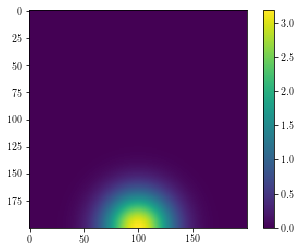

In [7]:
plt.imshow(u0.reshape(n, n))
plt.colorbar()
print(u0.max())

### Arnoldi method

In [8]:
gamma_trial = stop / 10
print("Gamma trial =", gamma_trial)

Gamma trial = 1e-05


In [9]:
y_test, _, conv_trial = sai.expm_ArnoldiSAI(A, u0.reshape((n**2, 1)), stop, gamma_trial, 1e-6, 1000)

Computing sparse LU factorization of the SAI matrix...
Done
Iteration = 1, resnorm = 68278.44486879413
Iteration = 2, resnorm = 101791.66565531061
Iteration = 3, resnorm = 99708.1942948501
Iteration = 4, resnorm = 103198.56779838126
Iteration = 5, resnorm = 106594.40061036087
Iteration = 6, resnorm = 104829.79127849599
Iteration = 7, resnorm = 82955.30354888515
Iteration = 8, resnorm = 58597.77138379733
Iteration = 9, resnorm = 91910.27911275637
Iteration = 10, resnorm = 32470.96714271775
Iteration = 11, resnorm = 62202.50556816593
Iteration = 12, resnorm = 75985.10692984264
Iteration = 13, resnorm = 35247.041962451396
Iteration = 14, resnorm = 42451.65632655135
Iteration = 15, resnorm = 69344.79288998198
Iteration = 16, resnorm = 50514.6867879378
Iteration = 17, resnorm = 30632.154991760883
Iteration = 18, resnorm = 61881.29009035311
Iteration = 19, resnorm = 62573.986980052425
Iteration = 20, resnorm = 34774.406388897194
Iteration = 21, resnorm = 63220.665350376876
Iteration = 22, re

Iteration = 179, resnorm = 2.7409377553832237e-06
Iteration = 180, resnorm = 2.2817446255879214e-06
Iteration = 181, resnorm = 1.7221453117346598e-06
Iteration = 182, resnorm = 1.1358992539312913e-06
Iteration = 183, resnorm = 5.678374193058595e-07


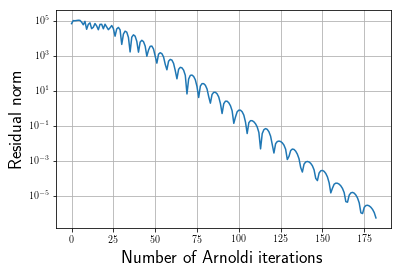

In [10]:
plt.semilogy(conv_trial[conv_trial > 0])
plt.xlabel("Number of Arnoldi iterations", fontsize=18)
plt.ylabel("Residual norm", fontsize=18)
plt.grid(True)

## Plot convergence for different $\gamma$

In [11]:
a = 0.01 * stop
b = 0.1 * stop
print(a, b)
gamma_range = np.linspace(a, b, num=10)

1.0000000000000002e-06 1e-05


In [12]:
conv4gamma = {}
for gamma in gamma_range:
    _, _, conv_trial = sai.expm_ArnoldiSAI(A, u0.reshape((n**2, 1)), stop, gamma, 1e-6, 500, disp=False)
    print("Gamma = {}, number of Arnoldi iterations = {}".format(gamma, sum(conv_trial > 0)))
    conv4gamma[gamma] = conv_trial

Gamma = 1.0000000000000002e-06, number of Arnoldi iterations = 64
Gamma = 2.0000000000000003e-06, number of Arnoldi iterations = 65
Gamma = 3e-06, number of Arnoldi iterations = 75
Gamma = 4.000000000000001e-06, number of Arnoldi iterations = 90
Gamma = 4.9999999999999996e-06, number of Arnoldi iterations = 104
Gamma = 6e-06, number of Arnoldi iterations = 117
Gamma = 7.000000000000001e-06, number of Arnoldi iterations = 127
Gamma = 8e-06, number of Arnoldi iterations = 143
Gamma = 9e-06, number of Arnoldi iterations = 159
Gamma = 1e-05, number of Arnoldi iterations = 183


Text(0, 0.5, 'Resnorm')

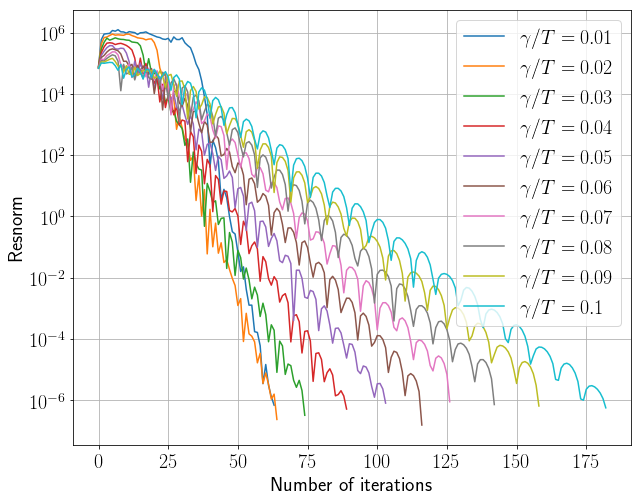

In [13]:
plt.figure(figsize=(10, 8))
for gamma in gamma_range:
    plt.semilogy(conv4gamma[gamma][conv4gamma[gamma] > 0], 
                 label=r"$\gamma / t = {}$".format(np.round(gamma/stop, 3)))
plt.legend(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(True)
plt.xlabel("Number of iterations", fontsize=20)
plt.ylabel("Resnorm", fontsize=20)


## Try optimize shift $\gamma$

In [14]:
# Generate gaussians as trial vectors 
batch_size = 1
# U = np.random.rand(A.shape[0], batch_size)
U = np.zeros((A.shape[0], batch_size))
x_range = np.linspace(-1, 1, num=n)
y_range = np.linspace(-1, 1, num=n)
for k in range(batch_size):
    x0, y0 = 2 * (np.random.rand(2) - 0.5)
    print(x0, y0)
    rv = spstat.multivariate_normal([x0, y0], [[0.05, 0.0], [0.0, 0.05]])
    x, y = np.meshgrid(x_range, y_range)
    pos = np.dstack((x, y))
    u0 = rv.pdf(pos)
    U[:, k] = u0.reshape(n**2)

0.8289922247453914 0.5536932046288994


### Brent from SciPy

In [15]:
import scipy.optimize as scopt

In [16]:
max_opt_iter = 30
tol = 1e-6
# batch_size = 1
# U = np.random.rand(A.shape[0], batch_size)
U0_trial = U
def objective_res(gamma_T_ratio):
    gamma = gamma_T_ratio * stop
    _, res_norm, _ = sai.expm_ArnoldiSAI(A.tocsc(), U0_trial, stop, gamma, tol, max_opt_iter, False)
    value = np.mean(res_norm**2)
    print("Objective = {}, gamma/T = {}".format(value, gamma_T_ratio))
    if np.isnan(value):
        return 100
    else:
        return value
    if value < tol:
        return 0
    else:
        return value
        

In [17]:
start_opt = time.time()
res_brent = scopt.fminbound(objective_res, 0.01, 0.1, xtol=1e-5, full_output=True, maxfun=50)
opt_time = time.time() - start_opt

Objective = 8542847.997187754, gamma/T = 0.04437694101250946
Objective = 24428771.596147344, gamma/T = 0.06562305898749053
Objective = 503203.2303202552, gamma/T = 0.031246117974981072
Objective = 1431992.1285142351, gamma/T = 0.023130823037528392
Objective = 572935.5690797751, gamma/T = 0.02886146321282058
Objective = 838033.6888124235, gamma/T = 0.031037136254416835
Objective = 58608.962484056785, gamma/T = 0.03626164607505678
Objective = 3956147.2625461672, gamma/T = 0.03936141291243375
Objective = 2751105.5512244417, gamma/T = 0.03434588481235804
Objective = 2782684.4777957425, gamma/T = 0.03744565164973502
Objective = 491509.14093337185, gamma/T = 0.03552989038703628
Objective = 704933.3187714325, gamma/T = 0.03671389596171452
Objective = 17153.425517457606, gamma/T = 0.035982140273694015
Objective = 6916.968776012281, gamma/T = 0.03607656562608013
Objective = 7007.08434901686, gamma/T = 0.03606843011916548
Objective = 6880.048278828242, gamma/T = 0.036079899494515406
Objective = 

In [18]:
print("Optimal gamma / T = {}".format(res_brent[0]))
print("Optimal gamma = {}".format(res_brent[0] *  stop))
print("Number of function calls = {}".format(res_brent[-1]))
print("Time for optimization = {}".format(opt_time))
gamma_opt_brent = res_brent[0] * stop
num_brent_iter = res_brent[-1]

Optimal gamma / T = 0.036139192121145386
Optimal gamma = 3.613919212114539e-06
Number of function calls = 22
Time for optimization = 13.261584281921387


In [19]:
u0 = data["v"]

In [20]:
_, _, conv_brent = sai.expm_ArnoldiSAI(A, u0.reshape((n**2, 1)), stop, gamma_opt_brent, 1e-6, 1000)

Computing sparse LU factorization of the SAI matrix...
Done
Iteration = 1, resnorm = 4135.865491546508
Iteration = 2, resnorm = 39007.62974747654
Iteration = 3, resnorm = 27326.091525020922
Iteration = 4, resnorm = 27590.984097027143
Iteration = 5, resnorm = 37878.37282407939
Iteration = 6, resnorm = 38316.91184129574
Iteration = 7, resnorm = 34488.88276909776
Iteration = 8, resnorm = 45136.97489721133
Iteration = 9, resnorm = 67156.48379637575
Iteration = 10, resnorm = 103334.57800568659
Iteration = 11, resnorm = 151110.1324228327
Iteration = 12, resnorm = 194883.1781860906
Iteration = 13, resnorm = 190330.1358207697
Iteration = 14, resnorm = 96221.96962494995
Iteration = 15, resnorm = 24256.794756205272
Iteration = 16, resnorm = 66134.9661819651
Iteration = 17, resnorm = 23402.66817188044
Iteration = 18, resnorm = 23577.771367048063
Iteration = 19, resnorm = 17294.33238112363
Iteration = 20, resnorm = 6954.383614616556
Iteration = 21, resnorm = 7700.2806849660665
Iteration = 22, resn

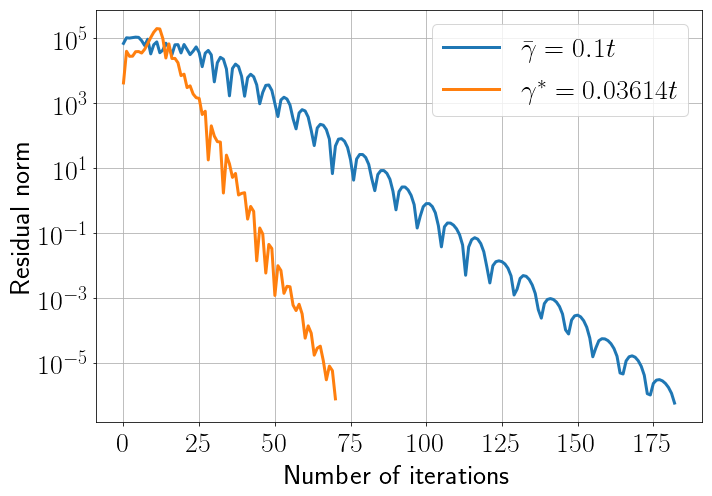

In [21]:
plt.figure(figsize=(10,7))
plt.semilogy(conv_trial[conv_trial > 0], linewidth=3, label=r"$\bar{\gamma} = 0.1t$")
plt.semilogy(conv_brent[conv_brent > 0], linewidth=3, label=r"$\gamma^*={}t$".format(np.round(res_brent[0], 5)))
plt.legend()
plt.grid(True)
# plt.xticks(ticks=np.arange(len(running_time_base), step=2), fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)
plt.xlabel(r"Number of iterations", fontsize=28)
plt.ylabel("Residual norm", fontsize=28)
plt.tight_layout()

## Plot dependence of time on the number ot test initial states

In [22]:
from IPython.display import clear_output

In [23]:
running_time_brent = [opt_time]
running_time_base = [0.0]
running_iters = 1000
brent_running_iters = []
base_running_iters = []

In [24]:
if n == 200:
    U_test = np.load("../data/u_test_200.npz")["U_test"]
elif n == 300:
    U_test = np.load("../data/u_test_300.npz")["U_test"]
else:
    raise ValueError("Dimensions differ from 200 and 300 are not supported!")
print(U_test.shape)
test_batch_size = U_test.shape[1]

(40000, 20)


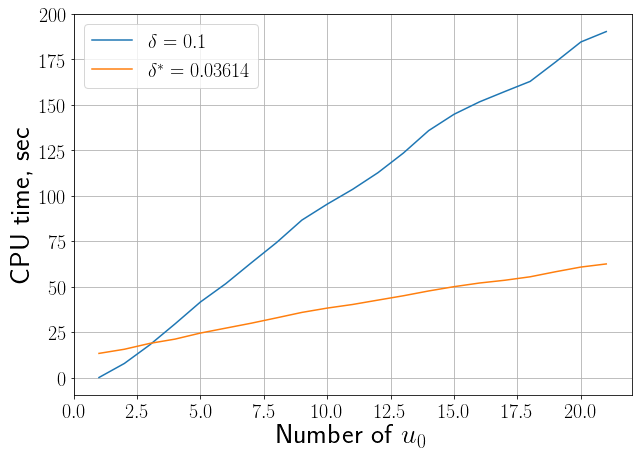

In [25]:
try:
    for j in range(test_batch_size):
        u0 = U_test[:, j][:, np.newaxis]
        start_brent = time.time()
        _, _, conv_brent = sai.expm_ArnoldiSAI(A, u0, stop, gamma_opt_brent, tol, running_iters, False)
        running_time_brent.append(running_time_brent[-1] + time.time() - start_brent)
        brent_running_iters.append(len(conv_brent[conv_brent > 0]))
        
        start_base = time.time()
        _, _, conv_base = sai.expm_ArnoldiSAI(A, u0, stop, gamma_trial, tol, running_iters, False)
        running_time_base.append(running_time_base[-1] + time.time() - start_base)
        base_running_iters.append(len(conv_base[conv_base > 0]))
        
        clear_output()
        plt.figure(figsize=(10,7))
        plt.plot(np.arange(len(running_time_base)), running_time_base, 
                 label=r"$\delta = 0.1$")
        plt.plot(np.arange(len(running_time_brent)), running_time_brent, 
                 label="$\delta^* = {}$".format(np.round(gamma_opt_brent/stop, 5)))
        plt.legend(fontsize=20)
        plt.xlabel(r"Number of $u_0$", fontsize=28)
        plt.ylabel("CPU time, sec", fontsize=28)
        plt.grid(True)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.show()
except KeyboardInterrupt:
    pass